In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry as geo
import geopandas as gpd
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
SCALING_FACTOR = 1
SCALING_FACTOR *= 2 # ASTRA gives count in both directions
SCALING_FACTOR *= 4 # Sample upscaling for MATSim simulation
#SCALING_FACTOR *= 0.92 # Correction factor

MATCHING_RADIUS = 100

In [3]:
df_counts = gpd.read_file("astra_count_stations.geojson")[["id", "name", "personal_count", "freight_count", "geometry"]]
df_counts["reference"] = df_counts["personal_count"] + df_counts["freight_count"]

df_flows = gpd.read_file("/run/media/sebastian/shoerl_data/astra1802/analysis/25pct/bl_2020_25pct.flow.shp")
df_flows["simulation"] = df_flows["day_conv"] + df_flows["day_truck"]
df_flows["simulation"] *= SCALING_FACTOR

In [4]:
factors = [1.0] # This is just for calibration, for production leave at 1.0
#factors = np.linspace(0.4, 0.6, 5)
scores = [] 

for factor in tqdm_notebook(factors):
    df_match = df_counts.copy()
    df_match["geometry"] = df_match["geometry"].buffer(MATCHING_RADIUS)
    df_match = gpd.sjoin(df_match, df_flows, op = "intersects", how = "left").drop(columns = ["index_right"])

    df_match["delta"] = factor * df_match["simulation"] - df_match["reference"]
    df_match["abs_delta"] = np.abs(df_match["delta"])
    df_match["geometry"] = df_match["geometry"].centroid

    df_match = df_match.sort_values(by = ["id", "abs_delta"])
    df_match = df_match.drop_duplicates("id")
    
    scores.append(df_match["abs_delta"].sum())

if len(factors) > 1:
    plt.plot(factors, scores)

In [5]:
dummy = df_match.loc[df_match["id"] == 2].copy()
dummy["id"] = -1
dummy["delta"] = np.max(np.abs(df_match["delta"]))
df_match = pd.concat([df_match, dummy])

dummy = df_match.loc[df_match["id"] == 2].copy()
dummy["id"] = -2
dummy["delta"] = -np.max(np.abs(df_match["delta"]))
df_match = pd.concat([df_match, dummy])

df_match.to_file("match_both.geojson", driver = "GeoJSON")

/home/sebastian/.local/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


Text(0, 0.5, 'Scaled simulation counts')

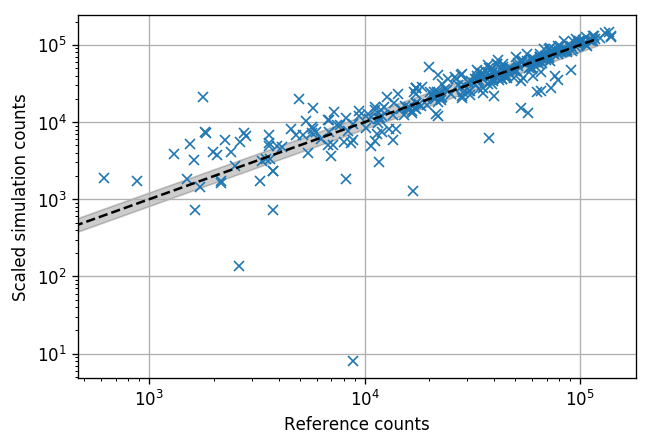

In [6]:
plt.figure(dpi = 120, figsize = (6,4))
plt.loglog(df_match["reference"], df_match["simulation"], 'x')
plt.loglog([0, 120000], [0, 120000], 'k--')

x = np.linspace(0, 120000, 100)
plt.fill_between(x, 0.8 * x, 1.2 * x, color = 'k', alpha = 0.2)
plt.grid()

plt.xlabel("Reference counts")
plt.ylabel("Scaled simulation counts")

In [7]:
df_comparison = df_match.copy()
df_comparison = df_comparison.rename(columns = { "geometry": "count_geometry" })

df_centroids = df_flows.copy()
df_centroids["geometry"] = df_centroids["geometry"].centroid
df_centroids = df_centroids.rename(columns = { "geometry": "link_geometry" })

df_comparison = pd.merge(df_comparison, df_centroids[["link_id", "link_geometry"]], on = "link_id")
df_comparison["geometry"] = [geo.LineString([a, b]) for a, b in zip(df_comparison["count_geometry"], df_comparison["link_geometry"])]
df_comparison["dist"] = [a.distance(b) for a, b in zip(df_comparison["count_geometry"], df_comparison["link_geometry"])]

del df_comparison["link_geometry"]
del df_comparison["count_geometry"]

df_comparison = gpd.GeoDataFrame(df_comparison, crs = {"init": "EPSG:2056"})
df_comparison.to_file("comparison_both.geojson", driver = "GeoJSON")